In [1]:
import os
import json
import skimage.io
import osmnx as ox
import numpy as np
import pandas as pd
import scipy.spatial
import networkx as nx
import matplotlib.pyplot as plt

In [2]:
cresi_dir = '/opt/cresi'
src_dir = os.path.join(cresi_dir, 'cresi')
config_dir = os.path.join(cresi_dir, 'cresi/configs')
weight_dir = os.path.join(cresi_dir, 'results/aws_weights')
test_im_raw_dir = os.path.join(cresi_dir, 'data/PS-MS')
test_im_clip_dir = os.path.join(cresi_dir, 'data/clips')
test_final_dir = os.path.join(cresi_dir, 'data/final_clips')
results_root_dir = os.path.join(cresi_dir, 'results')
results_dir = os.path.join(results_root_dir, 'dar_tutorial_cpu')
mask_pred_dir = os.path.join(results_dir, 'folds')
mask_stitched_dir = os.path.join(results_dir, 'stitched/mask_norm')

# make dirs
for d in [weight_dir, test_im_raw_dir, test_im_clip_dir, test_final_dir, mask_stitched_dir, mask_pred_dir]:
    os.makedirs(d, exist_ok=True)

In [3]:
#!aws s3 cp --recursive s3://spacenet-dataset/spacenet-model-weights/spacenet-5/baseline/ {weight_dir}

In [4]:
#!aws s3 ls --no-sign-request --recursive --human-readable --summarize s3://spacenet-dataset/AOIs/AOI_10_Dar_Es_Salaam/PS-MS

In [5]:
#!aws s3 cp --recursive s3://spacenet-dataset/AOIs/AOI_10_Dar_Es_Salaam/PS-MS/ {test_im_raw_dir}

-----
## 3. Prepare Test Data

While CRESI is designed to handle images of arbitrary size and extent, for this exercise we will clip the image somewhat to speed processing time and ease visualization. We will also convert the 8-band multispectral 16-bit image to an easier to visualize 8-bit RGB image. 

In [6]:
# Clip the image extent
ulx, uly, lrx, lry = 39.25252, -6.7580, 39.28430, -6.7880  # v0

im_name = [z for z in os.listdir(test_im_raw_dir) if z.endswith('.tif')][0]
print("im_name:", im_name)

test_im_raw = os.path.join(test_im_raw_dir, im_name)
test_im_tmp = os.path.join(test_im_clip_dir, im_name.split('.tif')[0] + '_clip.vrt')
print("temp file:", test_im_tmp)

test_im_clip = os.path.join(test_im_clip_dir, im_name.split('.tif')[0] + '_clip_60cm.tif')
print("output_file:", test_im_clip)

# clip to extent
!gdal_translate -projwin {ulx} {uly} {lrx} {lry} {test_im_raw} {test_im_tmp}

# resample 30 cm imagery to 60 cm
!gdal_translate -outsize 50% 50% {test_im_tmp} {test_im_clip}

im_name: AOI_10_Dar_Es_Salaam_PS-MS_COG.tif
temp file: /opt/cresi/data/clips/AOI_10_Dar_Es_Salaam_PS-MS_COG_clip.vrt
output_file: /opt/cresi/data/clips/AOI_10_Dar_Es_Salaam_PS-MS_COG_clip_60cm.tif
Input file size is 51038, 48420
Input file size is 11770, 11111
0...10...20...30...40...50...60...70...80...90...100 - done.


In [52]:
# Convert 16-bit multispectral test data to 8-bit RGB
%cd {os.path.join(cresi_dir, 'cresi/data_prep/')}
import create_8bit_images

create_8bit_images.dir_to_8bit(test_im_clip_dir, test_final_dir,
                              command_file_loc='',
                              rescale_type="perc",
                              percentiles=[2,98],
                              band_order=[5, 3, 2]) # specify [5,3,2] if MS channels. Here we are using RGB itself

# display our test image
fig_width, fig_height = 16, 16
im_test_name = [z for z in os.listdir(test_final_dir) if z.endswith('.tif')][0]
im_test_path = os.path.join(test_final_dir, im_test_name)
im_test = skimage.io.imread(im_test_path)

/opt/cresi/cresi/data_prep
im_files: ['AOI_10_Dar_Es_Salaam_PS-MS_COG_clip_60cm.tif']
bmin, bmax: 1 1956
zero_frac =  0.0
bmin, bmax: 1 1744
zero_frac =  0.0
bmin, bmax: 1 1820
zero_frac =  0.0
Conversion_command list: ['gdal_translate', '-ot', 'Byte', '-of', 'GTiff', '-a_nodata', '0', '-co', '"PHOTOMETRIC=rgb"', '-b 5', '-scale_1', '75.0', '702.0', '0', '255', '-b 3', '-scale_2', '87.0', '556.0', '0', '255', '-b 2', '-scale_3', '65.0', '470.0', '0', '255', '/opt/cresi/data/clips/AOI_10_Dar_Es_Salaam_PS-MS_COG_clip_60cm.tif', '/opt/cresi/data/final_clips/AOI_10_Dar_Es_Salaam_PS-MS_COG_clip_60cm.tif']
Conversion_command str: gdal_translate -ot Byte -of GTiff -a_nodata 0 -co "PHOTOMETRIC=rgb" -b 5 -scale_1 75.0 702.0 0 255 -b 3 -scale_2 87.0 556.0 0 255 -b 2 -scale_3 65.0 470.0 0 255 /opt/cresi/data/clips/AOI_10_Dar_Es_Salaam_PS-MS_COG_clip_60cm.tif /opt/cresi/data/final_clips/AOI_10_Dar_Es_Salaam_PS-MS_COG_clip_60cm.tif
Input file size is 5885, 5555
0...10...20...30...40...50...60...70.

In [54]:
im_test.shape

(5555, 5885, 3)

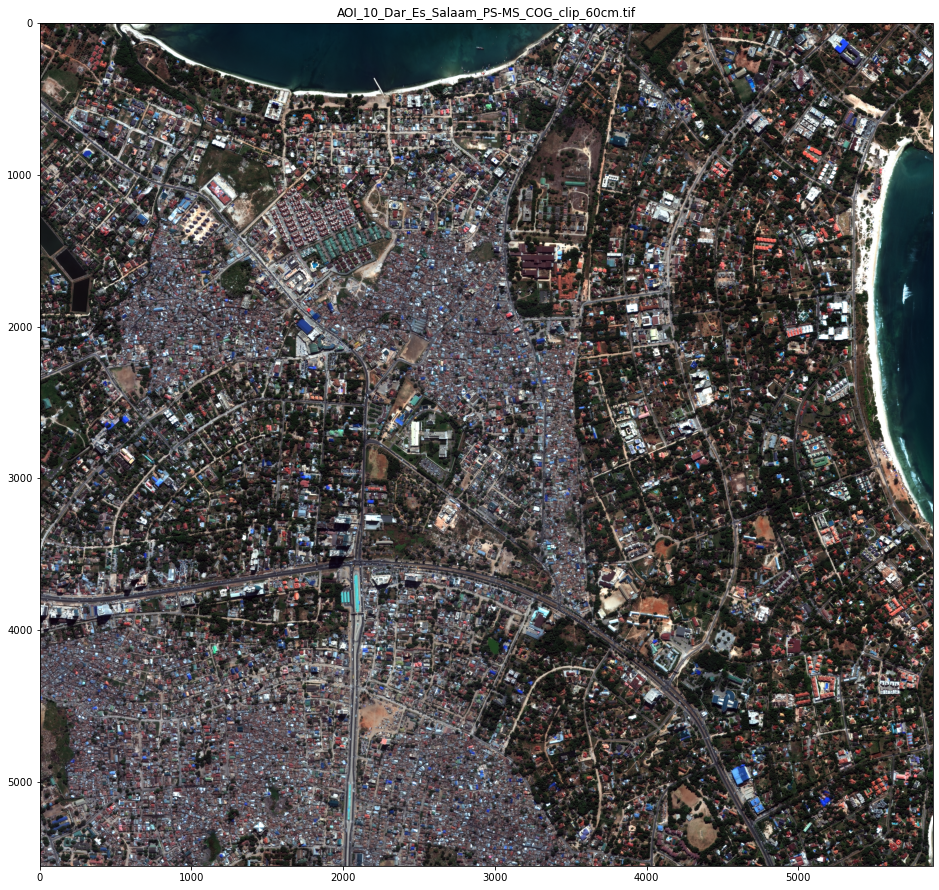

In [55]:
fig, ax = plt.subplots(figsize=(fig_width, fig_height))
_ = ax.imshow(im_test.squeeze())
_ = ax.set_title(im_test_name)

-----
## 4. Prepare the config file

CRESI reads from a .json configuration file, and for a pre-trained model executing inference requires only changing a few paths (namely, the testing imagery, model weights, and results paths) in the ```cresi/cresi/configs/dar_tutorial_cpu.json``` file.  These paths should already be set properly, but if not, exectue the cell below.

In [56]:
config_path = os.path.join(config_dir, 'dar_tutorial_cpu.json')
print("config path:", config_path)

# update directories
with open(config_path, 'r+') as f:
    data = json.load(f)
    data['path_src'] = src_dir
    
    data['path_data_root'] = os.path.join(src_dir, 'data')
    
    data['path_results_root'] = results_root_dir
    data['speed_conversion_file'] = os.path.join(config_dir, 'speed_conversion_binned7.csv')
    data['save_weights_dir'] = os.path.join(weight_dir, 'weights') 
    data['test_data_refined_dir'] = test_final_dir
    
    data['test_sliced_dir'] = test_final_dir + '_sliced'
    data['test_results_dir'] = 'dar_tutorial_cpu'

config path: /opt/cresi/cresi/configs/dar_tutorial_cpu.json


In [57]:
# write new values
os.remove(config_path)
with open(config_path, 'w') as f:
    json.dump(data, f, indent=4)

print("config data:")
data

config data:


{'path_src': '/opt/cresi/cresi',
 'path_results_root': '/opt/cresi/results',
 'speed_conversion_file': '/opt/cresi/cresi/configs/speed_conversion_binned7.csv',
 'save_weights_dir': '/opt/cresi/results/aws_weights/weights',
 'test_data_refined_dir': '/opt/cresi/data/final_clips',
 'test_sliced_dir': '/opt/cresi/data/final_clips_sliced',
 'test_results_dir': 'dar_tutorial_cpu',
 'slice_x': 1300,
 'slice_y': 1300,
 'stride_x': 1280,
 'stride_y': 1280,
 'skeleton_thresh': 0.25,
 'min_subgraph_length_pix': 600,
 'min_spur_length_m': 12,
 'rdp_epsilon': 1,
 'log_to_console': 0,
 'train_data_refined_dir_ims': '',
 'train_data_refined_dir_masks': '',
 'folds_file_name': 'folds4.csv',
 'folds_save_dir': 'folds',
 'tile_df_csv': 'tile_df.csv',
 'merged_dir': 'merged',
 'stitched_dir_raw': 'stitched/mask_raw',
 'stitched_dir_count': 'stitched/mask_count',
 'stitched_dir_norm': 'stitched/mask_norm',
 'wkt_submission': 'wkt_submission_nospeed.csv',
 'skeleton_dir': 'skeleton',
 'skeleton_pkl_dir': 

-----
## 5. Run Inference

The simplest option is to sipmly run the test.sh script (e.g. ```./test.sh configs/dar_tutorial_cpu.json```) which will execute all of the various inference scripts in series.  For this exercise, we will instead run the individual commands to view what's going on at each step.

### 5.1. 02_eval.py 

The 02_eval.py script applies the trained deep learning model to our testing imagery.  First, we tile the imagery into manageable sizes (~800 x 800 meters or 1300 x 1300 pixels). On windows inference proceeds at ~14 seconds per tile, and the entire process completes in 11 minutes for 25 tiles.

While running, you will see a progress bar something like:
```
20%|████████████████████████                                                                                  | 5/25 [02:27<09:42, 29.13s/it]
```

We will kick off inference

In [58]:
%cd {src_dir}
%run -i 02_eval.py configs/dar_tutorial_cpu.json

/opt/cresi/cresi
Executing inference on the CPU
Run utils.update_config()...
Updated config: {'path_src': '/opt/cresi/cresi', 'path_results_root': '/opt/cresi/results', 'path_data_root': '/opt/cresi/cresi/data', 'train_data_refined_dir_ims': '', 'train_data_refined_dir_masks': '', 'speed_conversion_file': '/opt/cresi/cresi/configs/speed_conversion_binned7.csv', 'folds_file_name': 'folds4.csv', 'save_weights_dir': '/opt/cresi/results/aws_weights/weights', 'num_folds': 1, 'default_val_perc': 0.2, 'num_channels': 3, 'num_classes': 8, 'network': 'resnet34', 'loss': {'soft_dice': 0.25, 'focal': 0.75}, 'early_stopper_patience': 5, 'nb_epoch': 70, 'test_data_refined_dir': '/opt/cresi/data/final_clips', 'test_results_dir': 'dar_tutorial_cpu', 'folds_save_dir': 'folds', 'tile_df_csv': 'tile_df.csv', 'test_sliced_dir': '/opt/cresi/data/final_clips_sliced', 'slice_x': 1300, 'slice_y': 1300, 'stride_x': 1280, 'stride_y': 1280, 'skeleton_band': 7, 'skeleton_thresh': 0.25, 'min_subgraph_length_pix':

  0%|                                                                                                                            | 0/25 [00:00<?, ?it/s]

  eval.py - predict() - executing...
  eval.py - predict() - batch.shape: torch.Size([1, 3, 1344, 1344])
  eval.py - predict() - pred1.shape: torch.Size([1, 8, 1344, 1344])
concrete_eval.py.process_batch()  predicted.shape; (1, 1344, 1344, 8)


  4%|████▋                                                                                                               | 1/25 [00:18<07:30, 18.76s/it]

  eval.py - predict() - executing...
  eval.py - predict() - batch.shape: torch.Size([1, 3, 1344, 1344])
  eval.py - predict() - pred1.shape: torch.Size([1, 8, 1344, 1344])
concrete_eval.py.process_batch()  predicted.shape; (1, 1344, 1344, 8)


  8%|█████████▎                                                                                                          | 2/25 [00:36<06:58, 18.18s/it]

  eval.py - predict() - executing...
  eval.py - predict() - batch.shape: torch.Size([1, 3, 1344, 1344])
  eval.py - predict() - pred1.shape: torch.Size([1, 8, 1344, 1344])
concrete_eval.py.process_batch()  predicted.shape; (1, 1344, 1344, 8)


 12%|█████████████▉                                                                                                      | 3/25 [00:54<06:37, 18.05s/it]

  eval.py - predict() - executing...
  eval.py - predict() - batch.shape: torch.Size([1, 3, 1344, 1344])
  eval.py - predict() - pred1.shape: torch.Size([1, 8, 1344, 1344])
concrete_eval.py.process_batch()  predicted.shape; (1, 1344, 1344, 8)


 16%|██████████████████▌                                                                                                 | 4/25 [01:13<06:28, 18.48s/it]

  eval.py - predict() - executing...
  eval.py - predict() - batch.shape: torch.Size([1, 3, 1344, 1344])
  eval.py - predict() - pred1.shape: torch.Size([1, 8, 1344, 1344])
concrete_eval.py.process_batch()  predicted.shape; (1, 1344, 1344, 8)


 20%|███████████████████████▏                                                                                            | 5/25 [01:33<06:22, 19.10s/it]

  eval.py - predict() - executing...
  eval.py - predict() - batch.shape: torch.Size([1, 3, 1344, 1344])
  eval.py - predict() - pred1.shape: torch.Size([1, 8, 1344, 1344])
concrete_eval.py.process_batch()  predicted.shape; (1, 1344, 1344, 8)


 24%|███████████████████████████▊                                                                                        | 6/25 [01:53<06:06, 19.30s/it]

  eval.py - predict() - executing...
  eval.py - predict() - batch.shape: torch.Size([1, 3, 1344, 1344])
  eval.py - predict() - pred1.shape: torch.Size([1, 8, 1344, 1344])


 28%|████████████████████████████████▍                                                                                   | 7/25 [02:11<05:41, 18.97s/it]

concrete_eval.py.process_batch()  predicted.shape; (1, 1344, 1344, 8)
  eval.py - predict() - executing...
  eval.py - predict() - batch.shape: torch.Size([1, 3, 1344, 1344])
  eval.py - predict() - pred1.shape: torch.Size([1, 8, 1344, 1344])
concrete_eval.py.process_batch()  predicted.shape; (1, 1344, 1344, 8)


 32%|█████████████████████████████████████                                                                               | 8/25 [02:29<05:17, 18.66s/it]

  eval.py - predict() - executing...
  eval.py - predict() - batch.shape: torch.Size([1, 3, 1344, 1344])
  eval.py - predict() - pred1.shape: torch.Size([1, 8, 1344, 1344])


 36%|█████████████████████████████████████████▊                                                                          | 9/25 [02:47<04:56, 18.53s/it]

concrete_eval.py.process_batch()  predicted.shape; (1, 1344, 1344, 8)
  eval.py - predict() - executing...
  eval.py - predict() - batch.shape: torch.Size([1, 3, 1344, 1344])
  eval.py - predict() - pred1.shape: torch.Size([1, 8, 1344, 1344])
concrete_eval.py.process_batch()  predicted.shape; (1, 1344, 1344, 8)


 40%|██████████████████████████████████████████████                                                                     | 10/25 [03:07<04:41, 18.78s/it]

  eval.py - predict() - executing...
  eval.py - predict() - batch.shape: torch.Size([1, 3, 1344, 1344])
  eval.py - predict() - pred1.shape: torch.Size([1, 8, 1344, 1344])


 44%|██████████████████████████████████████████████████▌                                                                | 11/25 [03:25<04:19, 18.51s/it]

concrete_eval.py.process_batch()  predicted.shape; (1, 1344, 1344, 8)
  eval.py - predict() - executing...
  eval.py - predict() - batch.shape: torch.Size([1, 3, 1344, 1344])
  eval.py - predict() - pred1.shape: torch.Size([1, 8, 1344, 1344])
concrete_eval.py.process_batch()  predicted.shape; (1, 1344, 1344, 8)


 48%|███████████████████████████████████████████████████████▏                                                           | 12/25 [03:42<03:57, 18.25s/it]

  eval.py - predict() - executing...
  eval.py - predict() - batch.shape: torch.Size([1, 3, 1344, 1344])
  eval.py - predict() - pred1.shape: torch.Size([1, 8, 1344, 1344])
concrete_eval.py.process_batch()  predicted.shape; (1, 1344, 1344, 8)


 52%|███████████████████████████████████████████████████████████▊                                                       | 13/25 [04:01<03:40, 18.37s/it]

  eval.py - predict() - executing...
  eval.py - predict() - batch.shape: torch.Size([1, 3, 1344, 1344])
  eval.py - predict() - pred1.shape: torch.Size([1, 8, 1344, 1344])
concrete_eval.py.process_batch()  predicted.shape; (1, 1344, 1344, 8)


 56%|████████████████████████████████████████████████████████████████▍                                                  | 14/25 [04:19<03:19, 18.14s/it]

  eval.py - predict() - executing...
  eval.py - predict() - batch.shape: torch.Size([1, 3, 1344, 1344])
  eval.py - predict() - pred1.shape: torch.Size([1, 8, 1344, 1344])


 60%|█████████████████████████████████████████████████████████████████████                                              | 15/25 [04:37<03:01, 18.15s/it]

concrete_eval.py.process_batch()  predicted.shape; (1, 1344, 1344, 8)
  eval.py - predict() - executing...
  eval.py - predict() - batch.shape: torch.Size([1, 3, 1344, 1344])
  eval.py - predict() - pred1.shape: torch.Size([1, 8, 1344, 1344])
concrete_eval.py.process_batch()  predicted.shape; (1, 1344, 1344, 8)


 64%|█████████████████████████████████████████████████████████████████████████▌                                         | 16/25 [04:54<02:39, 17.76s/it]

  eval.py - predict() - executing...
  eval.py - predict() - batch.shape: torch.Size([1, 3, 1344, 1344])
  eval.py - predict() - pred1.shape: torch.Size([1, 8, 1344, 1344])


 68%|██████████████████████████████████████████████████████████████████████████████▏                                    | 17/25 [05:11<02:20, 17.58s/it]

concrete_eval.py.process_batch()  predicted.shape; (1, 1344, 1344, 8)
  eval.py - predict() - executing...
  eval.py - predict() - batch.shape: torch.Size([1, 3, 1344, 1344])
  eval.py - predict() - pred1.shape: torch.Size([1, 8, 1344, 1344])
concrete_eval.py.process_batch()  predicted.shape; (1, 1344, 1344, 8)


 72%|██████████████████████████████████████████████████████████████████████████████████▊                                | 18/25 [05:29<02:04, 17.72s/it]

  eval.py - predict() - executing...
  eval.py - predict() - batch.shape: torch.Size([1, 3, 1344, 1344])
  eval.py - predict() - pred1.shape: torch.Size([1, 8, 1344, 1344])
concrete_eval.py.process_batch()  predicted.shape; (1, 1344, 1344, 8)


 76%|███████████████████████████████████████████████████████████████████████████████████████▍                           | 19/25 [05:46<01:45, 17.50s/it]

  eval.py - predict() - executing...
  eval.py - predict() - batch.shape: torch.Size([1, 3, 1344, 1344])
  eval.py - predict() - pred1.shape: torch.Size([1, 8, 1344, 1344])
concrete_eval.py.process_batch()  predicted.shape; (1, 1344, 1344, 8)


 80%|████████████████████████████████████████████████████████████████████████████████████████████                       | 20/25 [06:03<01:27, 17.54s/it]

  eval.py - predict() - executing...
  eval.py - predict() - batch.shape: torch.Size([1, 3, 1344, 1344])
  eval.py - predict() - pred1.shape: torch.Size([1, 8, 1344, 1344])
concrete_eval.py.process_batch()  predicted.shape; (1, 1344, 1344, 8)


 84%|████████████████████████████████████████████████████████████████████████████████████████████████▌                  | 21/25 [06:21<01:10, 17.57s/it]

  eval.py - predict() - executing...
  eval.py - predict() - batch.shape: torch.Size([1, 3, 1344, 1344])
  eval.py - predict() - pred1.shape: torch.Size([1, 8, 1344, 1344])


 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████▏             | 22/25 [06:39<00:53, 17.72s/it]

concrete_eval.py.process_batch()  predicted.shape; (1, 1344, 1344, 8)
  eval.py - predict() - executing...
  eval.py - predict() - batch.shape: torch.Size([1, 3, 1344, 1344])
  eval.py - predict() - pred1.shape: torch.Size([1, 8, 1344, 1344])


 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊         | 23/25 [06:57<00:35, 17.61s/it]

concrete_eval.py.process_batch()  predicted.shape; (1, 1344, 1344, 8)
  eval.py - predict() - executing...
  eval.py - predict() - batch.shape: torch.Size([1, 3, 1344, 1344])
  eval.py - predict() - pred1.shape: torch.Size([1, 8, 1344, 1344])


 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▍    | 24/25 [07:14<00:17, 17.63s/it]

concrete_eval.py.process_batch()  predicted.shape; (1, 1344, 1344, 8)
  eval.py - predict() - executing...
  eval.py - predict() - batch.shape: torch.Size([1, 3, 1344, 1344])
  eval.py - predict() - pred1.shape: torch.Size([1, 8, 1344, 1344])
concrete_eval.py.process_batch()  predicted.shape; (1, 1344, 1344, 8)


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [07:32<00:00, 18.09s/it]

Time to run 1 folds for 25 = 455.45908665657043 seconds


-----
### 5.1. 02_eval.py (continued)

The 02_eval.py script produce a multi-channel road masks for each image tile.  Each channel of this mask corresponds to a unique speed range.  For each of the testing tiles, the predicted mask will look something like the plot below.

mask_pred.shape: (8, 1300, 1300)


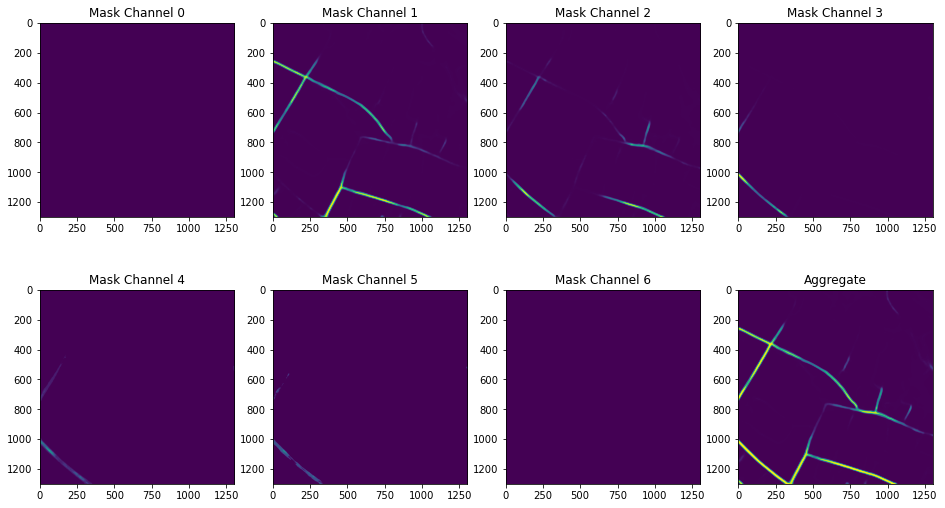

In [59]:
# inspect
mask_pred_file = 'fold0_0__AOI_10_Dar_Es_Salaam_PS-MS_COG_clip__5120__6400__1300__1300__11770__11111.tif'

mask_pred_file = 'fold0_0__AOI_10_Dar_Es_Salaam_PS-MS_COG_clip__0__0__1300__1300__11770__11111.tif'

mask_pred_path = os.path.join(mask_pred_dir, mask_pred_file)
mask_pred = skimage.io.imread(mask_pred_path)
print("mask_pred.shape:", mask_pred.shape)

# plot all layers
fig, axes = plt.subplots(2, 4, figsize=(16, 9))
for i, ax in enumerate(axes.flatten()):
    if i < (len(axes.flatten()) - 1):
        title = 'Mask Channel {}'.format(str(i))
    else:
        title = 'Aggregate' 
    ax.imshow(mask_pred[i,:,:])
    ax.set_title(title)

-----
### 5.2. 03b_stitch.py

The output of 02_eval.py is a series of chipped prediction masks, which we stitch back together (using the procedure illustrated below) in order to produce the aggregate prediction mask.  

<br>
<img src="images/basiss_test.jpg" alt="Drawing" style="height: 500px;"/>
<br>

The command below takes ~20 seconds to run for our test image, and creates the total mask. Many road extraction algorithms end here once a road pixel mask has been produced.  We still have a few more steps to go, however.

In [60]:
%cd {src_dir}
%run -i 03b_stitch.py configs/dar_tutorial_cpu.json

/opt/cresi/cresi
Running stitch.py...
post_process_image - w, h: 5885 5555
0 / 25
Compute overlay count mask...
Compute normalized mask...
mask_norm.dtype: uint8
mask_raw.dtype: uint16
overlay_count.dtype: uint8
np.max(overlay_count): 4
np.min(overlay_count): 1
Saving to files...
mask_norm.shape: (8, 5555, 5885)
mask_norm.dtype: uint8
Time to run stitch.py and create large masks (and save): 11.163120031356812 seconds


mask_pred.shape: (8, 5555, 5885)


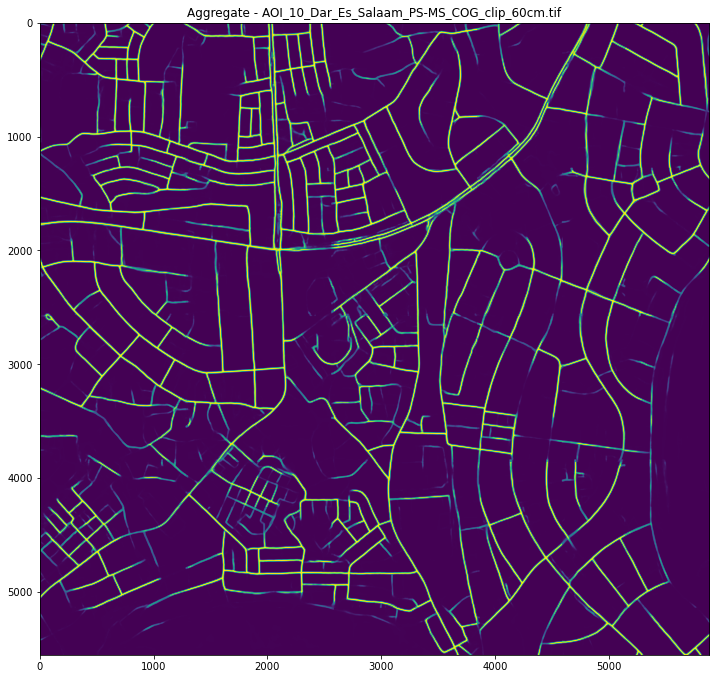

In [61]:
# Inspect the output
plot_all_layers = False
mask_pred_file = [z for z in os.listdir(mask_stitched_dir) if z.endswith('.tif')][0]
mask_pred_path = os.path.join(mask_stitched_dir, mask_pred_file)
mask_pred = skimage.io.imread(mask_pred_path)
print("mask_pred.shape:", mask_pred.shape)

# plot final layer
fig_width, fig_height = 12, 12
fig, ax = plt.subplots(figsize=(fig_width, fig_height))
_ = ax.imshow(mask_pred[-1,:,:])
_ = ax.set_title('Aggregate - ' + mask_pred_file)

# plot all layers (optional)
if plot_all_layers:
    fig, axes = plt.subplots(2, 4, figsize=(20, 11))
    for i, ax in enumerate(axes.flatten()):
        if i < (len(axes.flatten()) - 1):
            title = 'Mask Channel {}'.format(str(i))
        else:
            title = 'Aggregate' 
        ax.imshow(mask_pred[i,:,:])
        ax.set_title(title)

-----
### 5.3. 04_skeletonize.py

The 04_skeletonize script creates a graph from the aggregate mask via a multi-step process:
    
1. Refine aggregate mask via smoothing, openings, and closings.

2. Extract a skeleton of the refined mask.

3. Build a graph from the skeleton.  

Steps 1-3 are summarized in the figure below:

<br>
<img src="images/skeletonize.png" alt="Drawing" style="height: 180px;"/>
<br>

4. Clean out spurious edges and complete missing connections.

5. Output a csv of graph edges.  This csv output is included as a convenient intermediate step, since if speeds and geographic coordinates are not required we can forego Sections 5.4 and 5.5.

The 04_skeletonize.py script is multi-threaded to improve speed, and should take ~20 seconds to run.

In [62]:
%run -i 04_skeletonize.py configs/dar_tutorial_cpu.json

min_spur_length_pix: 20
Use_medial_axis? False
im_dir: /opt/cresi/results/dar_tutorial_cpu/stitched/mask_norm
out_ske_dir: /opt/cresi/results/dar_tutorial_cpu/skeleton
out_gdir: /opt/cresi/results/dar_tutorial_cpu/sknw_gpickle

 1 / 1 : AOI_10_Dar_Es_Salaam_PS-MS_COG_clip_60cm.tif
  img_loc: /opt/cresi/results/dar_tutorial_cpu/stitched/mask_norm/AOI_10_Dar_Es_Salaam_PS-MS_COG_clip_60cm.tif
  im_root: AOI_10_Dar_Es_Salaam_PS-MS_COG_clip_60cm
  out_ske_file: /opt/cresi/results/dar_tutorial_cpu/skeleton/AOI_10_Dar_Es_Salaam_PS-MS_COG_clip_60cm.tif
Executing make_skeleton...
make_skeleton(), input img_shape: ()
make_skeleton(), img.shape: (5555, 5885)
make_skeleton(), img.size: 32691175
make_skeleton(), img dtype: uint8
Run preprocess()...
Time to run preprocess(): 1.0942702293395996 seconds
skeletonize...
Time to run skimage.skeletonize(): 1.0137298107147217 seconds
fix_borders...
Time fix borders: 0.01635432243347168 seconds
ske.shape: (5555, 5885)
Time to run make_skeleton: 2.6087253093

In [63]:
# inspect the output
csv_path = os.path.join(results_dir, 'wkt_submission_nospeed.csv')
df = pd.read_csv(csv_path)
df.head()

,ImageId,WKT_Pix
0,AOI_10_Dar_Es_Salaam_PS-MS_COG_clip_60cm,"LINESTRING (121.0 2.0, 101.0 79.0, 75.0 150.0,..."
1,AOI_10_Dar_Es_Salaam_PS-MS_COG_clip_60cm,"LINESTRING (210.0 2.0, 208.0 27.0, 215.0 86.0)"
2,AOI_10_Dar_Es_Salaam_PS-MS_COG_clip_60cm,"LINESTRING (318.0 2.0, 318.0 35.0)"
3,AOI_10_Dar_Es_Salaam_PS-MS_COG_clip_60cm,"LINESTRING (571.0 2.0, 584.0 86.0)"
4,AOI_10_Dar_Es_Salaam_PS-MS_COG_clip_60cm,"LINESTRING (789.0 2.0, 773.0 20.0, 769.0 33.0)"


-----
### 5.4. 05_wkt_to_G.py

This script reads the csv output by 04_skeletonize.py back into graph format (which is very quick), and then uses the metadata encoded in our geotiff test image to assign geographic coordinates to the graph.  Assigning geo-coordinates for thousands of nodes is a computationally intensive process, so this script is multi-threaded to improve performance. The script outputs a [NetworkX](https://networkx.github.io) graph structure in ~60 seconds.

In [64]:
%run -i 05_wkt_to_G.py configs/dar_tutorial_cpu.json 

image_ids: ['AOI_10_Dar_Es_Salaam_PS-MS_COG_clip_60cm']
len image_ids: 1
image_file: /opt/cresi/data/final_clips/AOI_10_Dar_Es_Salaam_PS-MS_COG_clip_60cm.tif
  wkt_list[:2] ['LINESTRING (121.0 2.0, 101.0 79.0, 75.0 150.0, 71.0 170.0)'
 'LINESTRING (210.0 2.0, 208.0 27.0, 215.0 86.0)']
im_file: /opt/cresi/data/final_clips/AOI_10_Dar_Es_Salaam_PS-MS_COG_clip_60cm.tif
Running wkt_list_to_nodes_edges()...
Time to run wkt_list_to_nodes_egdes(): 0.21820497512817383 seconds
Creating G...
  len(G.nodes(): 3229
  len(G.edges(): 3336
Time to run nodes_edges_to_G(): 0.21192336082458496 seconds
Clean out short subgraphs
Running clean_sub_graphs...
  sub_graph node count: [2933, 3, 2, 2, 13, 3, 3, 7, 4, 4, 5, 4, 13, 2, 2, 6, 3, 4, 8, 4, 4, 4, 2, 3, 4, 10, 4, 3, 2, 5, 2, 6, 2, 4, 3, 2, 3, 8, 4, 2, 2, 12, 3, 7, 3, 2, 5, 6, 6, 5, 10, 8, 2, 10, 11, 3, 2, 7, 9, 3, 3, 2, 4, 2]
  len(G_.nodes()): 3229
  len(G_.edges()): 3336
 num bad_nodes: 270
 len(G'.nodes()): 2959
 len(G'.edges()): 3125
Time to run cle

Merge geometry_pix ...
0 10000 10003
  Applying rdp...
Merge geometry_latlon_wkt ...
0 10000 10003
  Applying rdp...
Merge geometry_utm_wkt ...
0 10000 10003
  Applying rdp...
Create 'geometry' field in edges...
13228 random node props: {'osmid': 13228, 'x_pix': 5286.0, 'y_pix': 5552.0, 'lon': 531057.6637939559, 'lat': -750319.9973741376, 'utm_east': 531057.663793958, 'utm_zone': 37, 'utm_letter': 'M', 'utm_north': 9249680.002633257, 'x': 531057.6637939559, 'y': -750319.9973741376}
random edge props for edge: (13214, 13221)  =  {'start': [13218, 13219, 13220, 13214], 'start_loc_pix': [(3760.0, 5532.0), (3781.0, 5552.0), (3682.0, 5468.0), (3691.0, 5479.0)], 'end': [13218, 13219, 13220, 13221], 'end_loc_pix': [(3760.0, 5532.0), (3786.0, 5552.0), (3781.0, 5552.0), (3691.0, 5479.0)], 'length_pix': 135.21841734017673, 'wkt_pix': 'LINESTRING (3682 5468, 3691 5479, 3760 5532, 3781 5552, 3786 5552)', 'geometry_pix': <shapely.geometry.linestring.LineString object at 0x7ffb152f0040>, 'osmid': 10

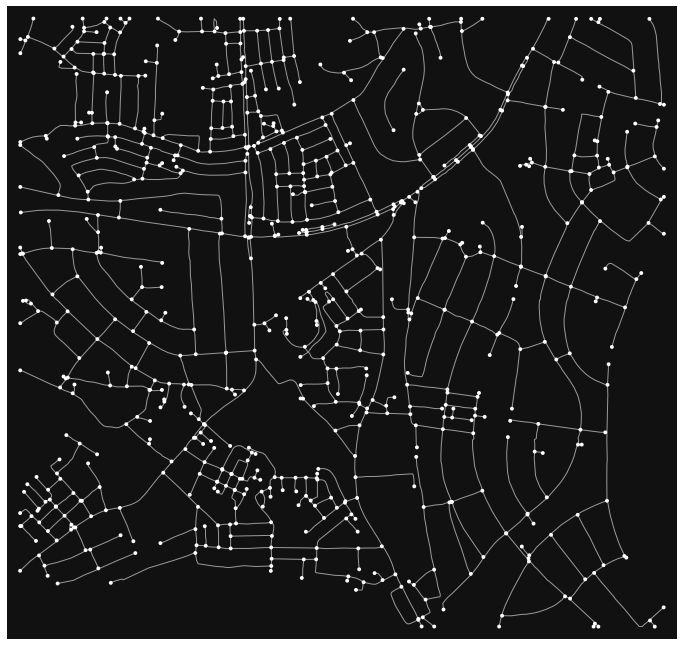

In [65]:
# inspect the output
gpickle_file = [z for z in os.listdir(os.path.join(results_dir, 'graphs')) if z.endswith('.gpickle')][0]
gpickle_path = os.path.join(results_dir, 'graphs', gpickle_file)
G0 = nx.read_gpickle(gpickle_path)
_, _ = ox.plot_graph(G0, figsize=(12,12))